sub10 folders: ['ADL', 'FALLS']
Data loaded. Shape: (355313, 7)
Labels: ['Standing' 'Sitting' 'Walking' 'Back_Sitting_Chair' 'Fall_Forward_Lying'
 'Sideward_Lying']
Final Data Shape: (355313, 7)

Labels Distribution:
 label
Walking               148408
Standing              145934
Sitting                17466
Sideward_Lying         14538
Back_Sitting_Chair     14521
Fall_Forward_Lying     14446
Name: count, dtype: int64


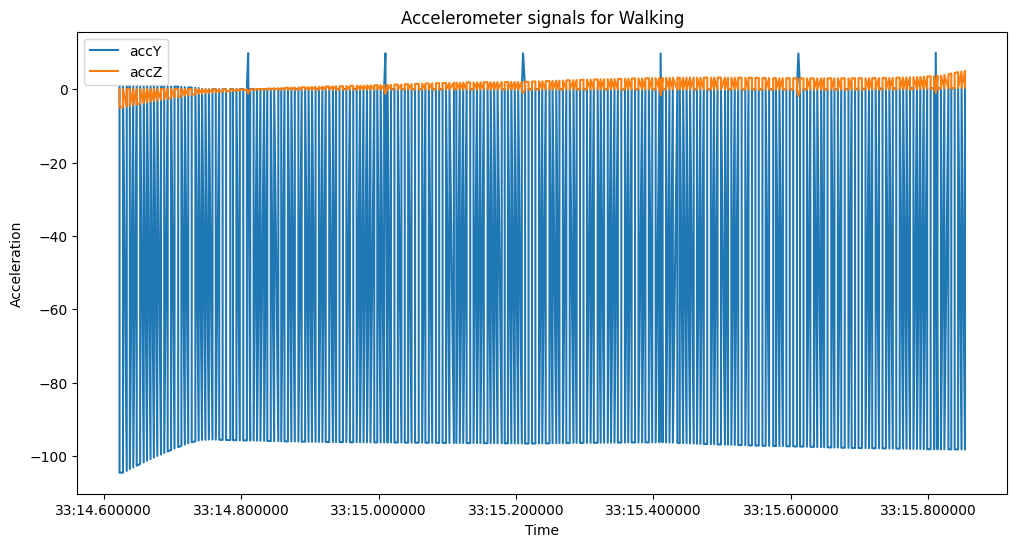

In [18]:
# -------------------------------
# 1. Import Libraries
# -------------------------------
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# -------------------------------
# 2. Set Root Path
# -------------------------------
root_path = "C:/Users/ELITEBOOK/Downloads/MobiFall_Dataset_v2.0/sub10"

# Check sub10 contents
print("sub10 folders:", os.listdir(root_path))

# -------------------------------
# 3. Define Desired Activities
# -------------------------------
activities = {
    "STD": "Standing",
    "SCH": "Sitting",
    "WAL": "Walking",
    "BSC": "Back_Sitting_Chair",
    "FOL": "Fall_Forward_Lying",
    "SDL": "Sideward_Lying"
}

parent_map = {
    "ADL": ["STD", "SCH", "WAL"],
    "FALLS": ["BSC", "FOL", "SDL"]
}

# -------------------------------
# 4. Function to Read MobiFall File
# -------------------------------
def read_mobifall_file(file_path):
    # Find the line number where @DATA is
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.strip() == "@DATA":
                start_row = i + 1
                break
    
    # Read data starting after @DATA
    df = pd.read_csv(file_path,
                     sep=",",
                     header=None,
                     skiprows=start_row,
                     engine="python")
    
    # Determine number of columns
    if df.shape[1] == 4:
        df.columns = ["timestamp_ns", "accX", "accY", "accZ"]
    elif df.shape[1] == 7:
        df.columns = ["timestamp_ns", "accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ"]
    else:
        raise ValueError(f"Unexpected number of columns in file {file_path}: {df.shape[1]}")
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp_ns'], unit='ns')
    
    return df

# -------------------------------
# 5. Load All Files Dynamically
# -------------------------------
data_list = []

for parent_folder, subfolders in parent_map.items():
    for subfolder in subfolders:
        folder_path = os.path.join(root_path, parent_folder, subfolder)
        if not os.path.exists(folder_path):
            print("Folder not found:", folder_path)
            continue
        
        for file in os.listdir(folder_path):
            if file.endswith(".txt"):
                file_path = os.path.join(folder_path, file)
                df = read_mobifall_file(file_path)
                df['label'] = activities[subfolder]
                df['file'] = file
                data_list.append(df)

# Combine all data
data = pd.concat(data_list, ignore_index=True)
print("Data loaded. Shape:", data.shape)
print("Labels:", data['label'].unique())

# -------------------------------
# 6. Timestamp Handling
# -------------------------------
data = data.sort_values(by='timestamp').reset_index(drop=True)

# -------------------------------
# 7. Handle Missing Values
# -------------------------------
data = data.fillna(method='ffill')

# -------------------------------
# 8. Remove Duplicates
# -------------------------------
data = data.drop_duplicates()

# -------------------------------
# 9. Summary
# -------------------------------
print("Final Data Shape:", data.shape)
print("\nLabels Distribution:\n", data['label'].value_counts())
data.head()

# -------------------------------
# 10. Optional: Plot Example
# -------------------------------
sample_label = "Walking"
sample_data = data[data['label'] == sample_label].iloc[:500]

plt.figure(figsize=(12,6))
plt.plot(sample_data['timestamp'], sample_data['accY'], label='accY')
plt.plot(sample_data['timestamp'], sample_data['accZ'], label='accZ')
plt.title(f"Accelerometer signals for {sample_label}")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()
